In [1]:
!pip install pyswarms
!pip install scikit-fuzzy
!pip install imblearn


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

# Load dataset
dataset_path = "3_cls"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check class mapping
print(dataset.class_to_idx)  # {'1': 0, '2': 1, '3': 2, '4': 3}

# Example: Load a batch
for images, labels in dataloader:
    print(f"Batch size: {images.shape}, Labels: {labels}")
    break


{'test': 0, 'train': 1}
Batch size: torch.Size([32, 3, 224, 224]), Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 0])


In [4]:
import os
import shutil
import random
from PIL import Image

# Set paths
dataset_path = "3_cls"  # Root dataset path
output_dir = "Processed_PDAD_Dataset"  # Output directory

# Define train-test split ratio
train_ratio = 0.8

# Target image size
img_size = (224, 224)

# Class labels
classes = ["PD", "Control", "AD"]

# Create train & test directories
for split in ["train", "test"]:
    for folder in classes:
        os.makedirs(os.path.join(output_dir, split, folder), exist_ok=True)

# Function to preprocess and save images
def process_and_split_images():
    for split in ["train", "test"]:  # Process both train and test folders
        for category in classes:  # Iterate through class folders
            class_path = os.path.join(dataset_path, split, category)
            if not os.path.exists(class_path):
                print(f"Warning: {class_path} not found. Skipping.")
                continue

            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            random.shuffle(images)  # Shuffle for randomness

            split_index = int(len(images) * train_ratio)
            train_images, test_images = images[:split_index], images[split_index:]

            # Save images
            for image_name in train_images:
                process_and_save(image_name, class_path, os.path.join(output_dir, "train", category))

            for image_name in test_images:
                process_and_save(image_name, class_path, os.path.join(output_dir, "test", category))

# Function to load, preprocess, and save images
def process_and_save(image_name, src_folder, dest_folder):
    src_path = os.path.join(src_folder, image_name)
    dest_path = os.path.join(dest_folder, image_name)

    try:
        with Image.open(src_path) as img:
            img = img.convert("RGB")  # Convert to RGB (if grayscale)
            img = img.resize(img_size)  # Resize image
            img.save(dest_path)  # Save processed image
    except Exception as e:
        print(f"Error processing {src_path}: {e}")

# Run preprocessing
process_and_split_images()
print("Dataset Preprocessing & Splitting Completed!")


Dataset Preprocessing & Splitting Completed!


In [6]:
import csv
import os
from collections import Counter

# Define CSV file path
csv_file = os.path.join(output_dir, "pdad_dataset_info.csv")

# Collect image data
image_data = []
labels = []
for split in ["train", "test"]: 
     split_dir = os.path.join("3_cls", split)
     split_dir = os.path.join(output_dir, split)
     for category in ["PD", "Control","AD","AD"]:
        category_dir = os.path.join(split_dir, category)
        for image_name in os.listdir(category_dir):
            image_path = os.path.join(category_dir, image_name)
            image_data.append([image_path, image_name, category])
            labels.append(category)

# Write to CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image_Path", "Image_Name", "Label"])
    writer.writerows(image_data)

print(f"CSV file saved at {csv_file}")

CSV file saved at Processed_PDAD_Dataset\pdad_dataset_info.csv


In [7]:
import pandas as pd
df=pd.read_csv("Processed_PDAD_Dataset/pdad_dataset_info.csv")

In [8]:
# View the first few rows
print(df.head())

# Check basic information
print(df.info())

# Check the label distribution
print(df['Label'].value_counts())


                                   Image_Path  Image_Name Label
0    Processed_PDAD_Dataset\train\PD\PD_1.png    PD_1.png    PD
1   Processed_PDAD_Dataset\train\PD\PD_10.png   PD_10.png    PD
2  Processed_PDAD_Dataset\train\PD\PD_100.png  PD_100.png    PD
3  Processed_PDAD_Dataset\train\PD\PD_103.png  PD_103.png    PD
4  Processed_PDAD_Dataset\train\PD\PD_104.png  PD_104.png    PD
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10981 entries, 0 to 10980
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  10981 non-null  object
 1   Image_Name  10981 non-null  object
 2   Label       10981 non-null  object
dtypes: object(3)
memory usage: 257.5+ KB
None
Label
AD         6400
Control    3655
PD          926
Name: count, dtype: int64


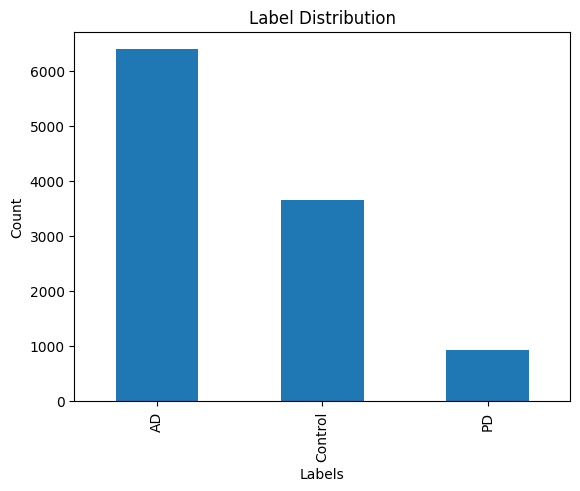

In [9]:
import matplotlib.pyplot as plt

# Plot label distribution
df['Label'].value_counts().plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()


In [10]:
from collections import Counter
# Calculate class weights
label_counts = Counter(labels)
total_samples = sum(label_counts.values())
class_weights = {label: total_samples / (len(label_counts) * count) for label, count in label_counts.items()}

print("Class Weights:", class_weights)


Class Weights: {'PD': 3.9528437724982, 'Control': 1.0014591883264934, 'AD': 0.5719270833333333}


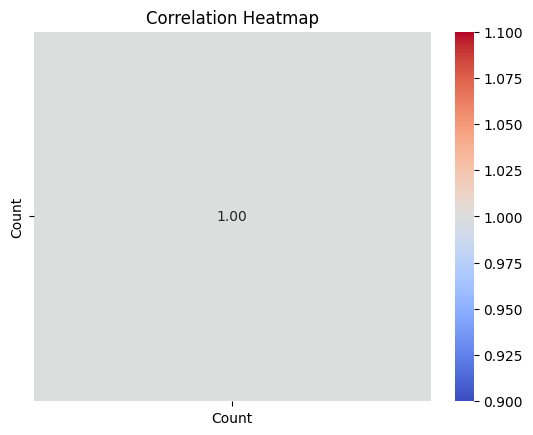

In [11]:
import seaborn as sns
# Create a correlation heatmap
df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


Summary of Steps
Use descriptive statistics to understand the dataset.
Plot label distributions and pixel intensity histograms.
Visualize class imbalances to determine the need for class weights.
Explore correlations (if applicable).
Check image augmentation and ensure consistency in preprocessing.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the model with Swish activation
class SwishResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(SwishResNet, self).__init__()
        # Load pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        # Replace ReLU with Swish in the model
        self.resnet.relu = Swish()
        # Modify the final layer to match the number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
model = SwishResNet()

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:15<00:00, 3.09MB/s]


In [14]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import random

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define a CNN model with Swish activation
class SwishResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(SwishResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.relu = Swish()  # Replace ReLU with Swish
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        df = pd.read_csv(csv_file)
        self.transform = transform
        self.data = df.groupby("Label").head(10).reset_index(drop=True)  # 10 images per label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label_mapping = {"PD": 0, "Control": 1, "AD": 2}  # Adjust if needed
        label = label_mapping[self.data.iloc[idx, 2]]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
csv_file = "Processed_PDAD_Dataset/pdad_dataset_info.csv"
dataset = ImageDataset(csv_file, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Mayfly Algorithm for hyperparameter tuning
def mayfly_optimization(num_mayflies=5, generations=1):
    best_lr, best_wd = 0.0001, 0.0005  # Default values
    best_acc = 0.0

    mayflies = [(random.uniform(1e-5, 1e-3), random.uniform(1e-6, 1e-3)) for _ in range(num_mayflies)]
    
    for gen in range(generations):
        for i, (lr, wd) in enumerate(mayflies):
            model = SwishResNet(num_classes=4).to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            criterion = nn.CrossEntropyLoss()
            
            model.train()
            correct, total = 0, 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            acc = 100 * correct / total
            if acc > best_acc:
                best_acc = acc
                best_lr, best_wd = lr, wd
            
            # Ensure learning rate and weight decay are positive and adaptive
            mayflies[i] = (
                max(1e-5, best_lr * (1 + random.uniform(-0.1, 0.1))),  # Adjust LR in small steps
                max(1e-6, best_wd * (1 + random.uniform(-0.1, 0.1)))   # Adjust WD adaptively
            )
        
        print(f"Generation {gen+1}: , Best LR = {best_lr:.6f}, Best WD = {best_wd:.6f}")
    
    return best_lr, best_wd

# Find best hyperparameters
best_lr, best_wd = mayfly_optimization()

# Train final model with optimized hyperparameters
model = SwishResNet(num_classes=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, criterion, optimizer, epochs=15):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100-correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 -correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and test with optimized parameters
train_model(model, train_loader, criterion, optimizer, epochs=2)
test_model(model, test_loader)


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generation 1: , Best LR = 0.000450, Best WD = 0.000509
Epoch 1/2, Loss: 6.4079, Accuracy: 99.50%
Epoch 2/2, Loss: 6.3727, Accuracy: 99.33%
Test Accuracy: 99.67%


****

In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# **Fuzzy Decision-Based Classification**
def fuzzy_decision(output_probs, threshold=0.6):
    """
    Apply fuzzy logic to classify an image.
    If the highest probability is below a threshold, classify as 'uncertain'.
    """
    max_prob, pred_class = torch.max(output_probs, dim=1)  # Get highest probability and class index
    pred_class[max_prob < threshold] = -1  # If probability is low, mark as 'uncertain'
    return pred_class.cpu().numpy()

# Testing function with fuzzy decision logic
def test_model(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Convert to probabilities
            preds = fuzzy_decision(probs)  # Apply fuzzy decision logic

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds)

    return true_labels, predicted_labels

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=20)

# Evaluate the model
y_true, y_pred = test_model(model, test_loader)

# Convert -1 to "Uncertain" class
y_pred = np.array(y_pred)
y_pred_labels = np.where(y_pred == -1, "Uncertain", y_pred)
# Convert all true and predicted labels to strings
y_true_str = [str(label) for label in y_true]
y_pred_str = [str(label) for label in y_pred_labels]

# Now, generate the classification report
print("\nClassification Report:\n")
print(classification_report(y_true_str, y_pred_str, zero_division=1))




Epoch 1/20, Loss: 3.4469, Accuracy: 99.29%
Epoch 2/20, Loss: 3.0348, Accuracy: 99.25%
Epoch 3/20, Loss: 2.0310, Accuracy: 99.12%
Epoch 4/20, Loss: 1.2011, Accuracy: 99.08%
Epoch 5/20, Loss: 1.8622, Accuracy: 99.12%
Epoch 6/20, Loss: 5.2915, Accuracy: 99.17%
Epoch 7/20, Loss: 3.6775, Accuracy: 99.42%
Epoch 8/20, Loss: 2.8195, Accuracy: 99.21%
Epoch 9/20, Loss: 2.1680, Accuracy: 99.17%
Epoch 10/20, Loss: 1.7127, Accuracy: 99.12%
Epoch 11/20, Loss: 0.4490, Accuracy: 99.00%
Epoch 12/20, Loss: 1.9989, Accuracy: 99.17%
Epoch 13/20, Loss: 0.8809, Accuracy: 99.04%
Epoch 14/20, Loss: 1.8003, Accuracy: 99.25%
Epoch 15/20, Loss: 0.8081, Accuracy: 99.04%
Epoch 16/20, Loss: 0.6250, Accuracy: 99.00%
Epoch 17/20, Loss: 1.1908, Accuracy: 99.08%
Epoch 18/20, Loss: 1.9138, Accuracy: 99.12%
Epoch 19/20, Loss: 1.6827, Accuracy: 99.12%
Epoch 20/20, Loss: 2.1749, Accuracy: 99.12%

Classification Report:

              precision    recall  f1-score   support

           0       0.67      1.00      0.80      